In [15]:
import yfinance as yf
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt

# 1: Pick a stock of your choice which is being traded in the derivative market.
stock_symbol = "GOOG"  # Alphabet Inc. (GOOG)

# 2.Look at the stock’s and option’s history on YAHOO Finance.
stock_data = yf.download(stock_symbol, start="2023-04-01", end="2024-04-01")

# Display stock data
print("Historical Stock Data:")
print(stock_data.head())



[*********************100%%**********************]  1 of 1 completed

Historical Stock Data:
                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2023-04-03  102.669998  104.949997  102.379997  104.910004  104.910004   
2023-04-04  104.839996  106.099998  104.599998  105.120003  105.120003   
2023-04-05  106.120003  106.540001  104.101997  104.949997  104.949997   
2023-04-06  105.769997  109.629997  104.815002  108.900002  108.900002   
2023-04-10  107.389999  107.970001  105.599998  106.949997  106.949997   

              Volume  
Date                  
2023-04-03  20719900  
2023-04-04  20377200  
2023-04-05  21864200  
2023-04-06  34684200  
2023-04-10  19741500  


In [60]:
# Retrieve available expiration dates
expirations = yf.Ticker(stock_symbol).options

# Select the first available expiration date
if expirations:
    first_expiration = expirations[0]

    # Retrieve option chain data for the selected expiration date
    option_chain = yf.Ticker(stock_symbol).option_chain(first_expiration)

    # Display option chain data
    print("\nOption Chain Data:")
    print(option_chain.calls.head())
    print(option_chain.puts.head())

    # Fix strike price and time to maturity
    K = option_chain.calls['strike'][0]  # Example: use the strike price of the first call option
    T = (np.datetime64(first_expiration) - np.datetime64(stock_data.index[-1])).astype('timedelta64[D]').astype(int) / 365  # Example: time to maturity in years





Option Chain Data:
        contractSymbol             lastTradeDate  strike  lastPrice    bid  \
0  GOOG240426C00090000 2024-03-15 17:41:35+00:00    90.0      52.31  67.40   
1  GOOG240426C00100000 2024-04-19 19:35:41+00:00   100.0      55.60  53.70   
2  GOOG240426C00105000 2024-04-19 19:57:00+00:00   105.0      51.92  48.65   
3  GOOG240426C00110000 2024-04-18 17:11:47+00:00   110.0      46.52  43.70   
4  GOOG240426C00115000 2024-04-05 19:38:49+00:00   115.0      39.25  38.90   

     ask    change  percentChange  volume  openInterest  impliedVolatility  \
0  71.25  0.000000       0.000000     NaN             2           3.492189   
1  57.60 -4.150002      -6.945609    19.0             8           2.447270   
2  52.65 -0.630001      -1.198860    32.0            49           2.247563   
3  47.65 -1.479999      -3.083333     1.0            35           2.038091   
4  42.65  0.000000       0.000000     6.0             8           0.933594   

   inTheMoney contractSize currency  
0   

In [61]:

    # Calculate current stock price
    S = stock_data['Adj Close'][-1]
    print(S)

    # Estimate annual volatility
    stock_data['Daily Return'] = stock_data['Adj Close'].pct_change()
    volatility = stock_data['Daily Return'].std() * np.sqrt(252)  # 252 trading days in a year

    print("Estimated annual volatility for {} based on past one-year data: {:.2f}%".format(stock_symbol, volatility * 100))
    treasury_data = yf.download("^TNX", start="2023-04-01", end="2024-04-01")  # ^TNX is the ticker symbol for the 10-year US Treasury rate

    #4.Use 10 years’ US treasury rate or any other rate as the rate of interest.
    risk_free_rate = treasury_data['Close'][-1] / 100  # Assuming the rate is provided in percentage terms, convert to decimal

    print("Risk-free rate based on 10-year US Treasury rate: {:.2%}".format(risk_free_rate))
#Evaluate the option price by using Black Scholes Formula
  # Function to calculate option price using Black-Scholes formula
    def black_scholes(S, K, T, r, sigma, option_type='call'):
        d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
        d2 = d1 - sigma * np.sqrt(T)

        if option_type == 'call':
            option_price = S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
        elif option_type == 'put':
            option_price = K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)

        return option_price

         # Calculate option price using Black-Scholes formula
    black_scholes_option_price = black_scholes(S, K, T, risk_free_rate, volatility)
    print("Option Price (Black-Scholes Formula):", black_scholes_option_price)

# Increase the number of steps in Binomial model to verify that the price converges to 6
    #Increase the number of steps in Binomial model
# We can use more steps to verify that the price converges to the Black-Scholes price
    num_steps = 100

    # Calculate option price using one-step Binomial model
    def binomial_option_price(S, K, T, r, sigma, num_steps=1, option_type='call'):
        dt = T / num_steps
        u = np.exp(sigma * np.sqrt(dt))
        d = 1 / u
        p = (np.exp(r * dt) - d) / (u - d)

        # Generate stock price paths
        stock_prices = np.zeros((num_steps + 1, num_steps + 1))
        stock_prices[0, 0] = S

        for i in range(1, num_steps + 1):
            stock_prices[i, 0] = stock_prices[i - 1, 0] * u
            for j in range(1, i + 1):
                stock_prices[i, j] = stock_prices[i - 1, j - 1] * d

        # Calculate option prices at maturity
        option_values = np.zeros((num_steps + 1, num_steps + 1))
        for j in range(num_steps + 1):
            option_values[num_steps, j] = max(0, K - stock_prices[num_steps, j]) if option_type == 'put' else max(0, stock_prices[num_steps, j] - K)

        # Backward induction to calculate option prices at earlier times
        for i in range(num_steps - 1, -1, -1):
            for j in range(i + 1):
                option_values[i, j] = np.exp(-r * dt) * (p * option_values[i + 1, j] + (1 - p) * option_values[i + 1, j + 1])

        return option_values[0, 0]


# Calculate option price using one-step Binomial model
    binomial_option_price_one_step = binomial_option_price(S, K, T, risk_free_rate, volatility, num_steps=1)
    print("Option Price (Binomial Model - One Step):", binomial_option_price_one_step)




[*********************100%%**********************]  1 of 1 completed

152.25999450683594
Estimated annual volatility for GOOG based on past one-year data: 27.31%
Risk-free rate based on 10-year US Treasury rate: 4.21%
Option Price (Black-Scholes Formula): 62.560250334547305
Option Price (Binomial Model - One Step): 62.560250334543404


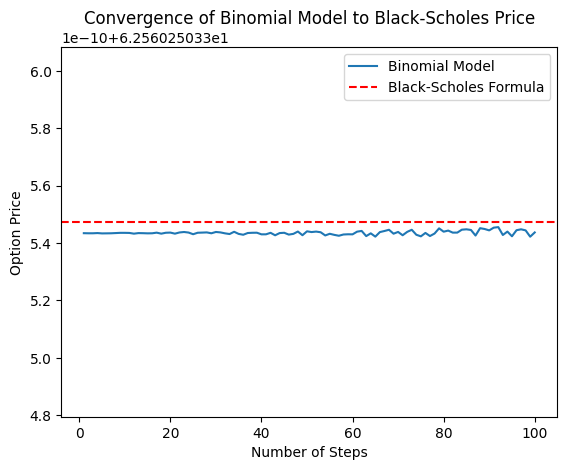

In [53]:
    # Plot option prices for increasing number of steps in Binomial model
    num_steps_range = range(1, 101)
    binomial_option_prices = [binomial_option_price(S, K, T, risk_free_rate, volatility, num_steps=n) for n in num_steps_range]

    plt.plot(num_steps_range, binomial_option_prices, label='Binomial Model')
    plt.axhline(y=black_scholes_option_price, color='r', linestyle='--', label='Black-Scholes Formula')
    plt.xlabel('Number of Steps')
    plt.ylabel('Option Price')
    plt.title('Convergence of Binomial Model to Black-Scholes Price')
    plt.legend()
    plt.show()


Creating a delta-neutral portfolio involves adjusting the positions in the underlying stock and its options to ensure that the overall delta of the portfolio is zero. Delta is one of the Option Greeks, and it measures the sensitivity of an option's price to a $1 change in the price of the underlying asset. A delta-neutral portfolio is not affected by small movements in the price of the underlying asset because the positive and negative deltas balance each other out. Here's a step-by-step approach to creating a delta-neutral portfolio: Calculate Delta for Options: Determine the delta for each option in the portfolio. The delta for call options will be a positive number between 0 and 1, and for put options, it will be a negative number between 0 and -1. Assess Portfolio Delta: Calculate the current delta of the portfolio by summing the deltas of all individual positions, taking into account the number of shares or contracts for each position. For example, if you have 100 shares of a stock (delta of 1 per share) and 2 put option contracts (with a delta of -0.5 each and 100 shares per contract), the portfolio delta would be 100 ∗ 1 + 2 ∗ − 0.5 ∗ 100 = 0 100∗1+2∗−0.5∗100=0. Adjust Positions: If the portfolio delta is not zero, adjust the positions to achieve delta neutrality. This can be done by: Buying or selling shares of the underlying stock. Buying or selling options with a delta that will offset the current portfolio delta. Using options strategies such as straddles, strangles, or spreads to adjust the overall delta. Monitor and Rebalance: Since delta changes with the stock price and over time, regularly monitor the portfolio's delta and rebalance as necessary to maintain delta neutrality.

In [65]:
#Use numerical methods to get implied volatility? You can use Excel, Python and R forcoding.

import numpy as np
from scipy.stats import norm
from scipy.optimize import newton

# Black-Scholes formula for a European call option
def black_scholes_call(S, K, T, r, sigma):
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    call_price = S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    return call_price

# Vega of the Black-Scholes formula (derivative with respect to sigma)
def vega(S, K, T, r, sigma):
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    return S * norm.pdf(d1) * np.sqrt(T)

# Function to find the root (implied volatility)
def find_implied_volatility(target_value, *args):
    return lambda sigma: black_scholes_call(*args, sigma) - target_value

# Market and option parameters
market_price = 10  # Market price of the option
S = 100  # Underlying stock price
K = 100  # Strike price
T = 1  # Time to maturity in years
r = 0.05  # Risk-free interest rate

# Initial guess for the implied volatility
initial_guess = 0.2

# Use the Newton-Raphson method to solve for sigma
implied_volatility = newton(find_implied_volatility(market_price, S, K, T, r), initial_guess, fprime=lambda sigma: vega(S, K, T, r, sigma))

print(f"The implied volatility is: {implied_volatility:.4f}")

The implied volatility is: 0.1880


In [81]:
    # Step 13: Function to calculate Option Greeks
    def calculate_option_greeks(S, K, T, r, sigma):
        delta = norm.cdf((np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T)))
        gamma = norm.pdf((np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))) / (S * sigma * np.sqrt(T))
        theta = -((S * norm.pdf((np.log(S / K) + (r + 0.5 * sigma * 2) * T) / (sigma * np.sqrt(T))) * sigma) / (2 * np.sqrt(T))) - r * K * np.exp(-r * T) * norm.cdf((np.log(S / K) + (r - 0.5 * sigma * 2) * T) / (sigma * np.sqrt(T)))
        vega = S * norm.pdf((np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))) * np.sqrt(T)
        rho = K * T * np.exp(-r * T) * norm.cdf((np.log(S / K) + (r - 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T)))
        return delta, gamma, theta, vega, rho

    # Step 14: Calculate Option Greeks
    delta, gamma, theta, vega, rho = calculate_option_greeks(S, K, T, risk_free_rate, volatility)

    # Print Option Greeks
    print("\nOption Greeks:")
    print("Delta:", delta)
    print("Gamma:", gamma)
    print("Theta:", theta)
    print("Vega:", vega)
    print("Rho:", rho)




Option Greeks:
Delta: 0.6143068557232568
Gamma: 0.014006137755372936
Theta: -3.6002769846551805
Vega: 38.24521676393537
Rho: 48.610035027102384


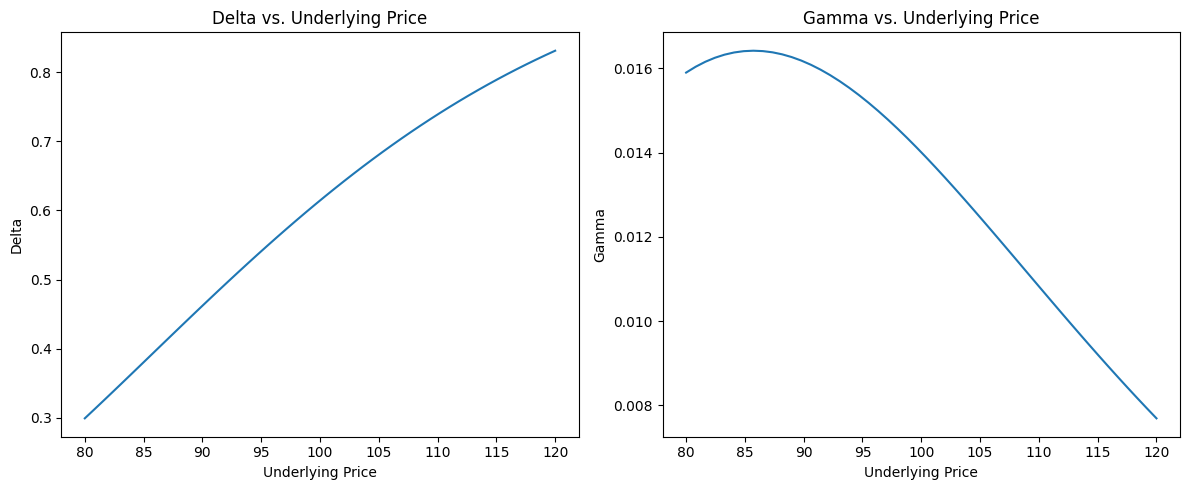

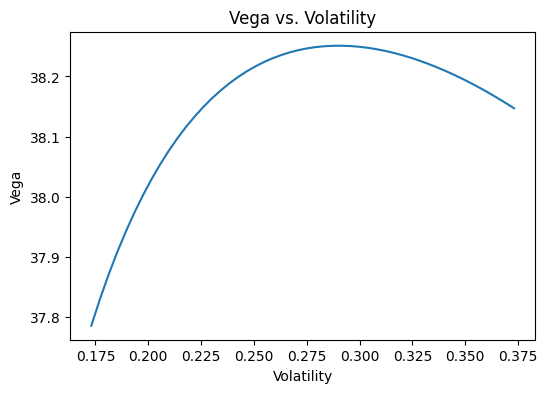

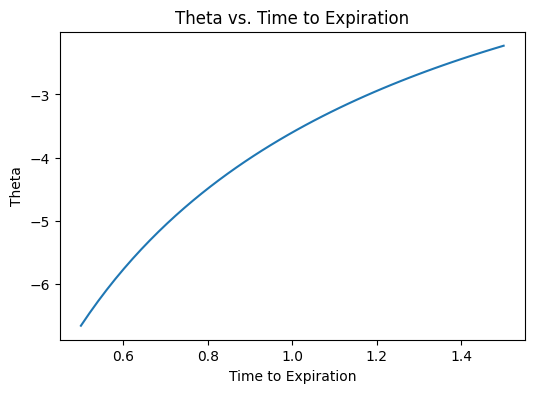

In [82]:

    # Visualize the impact of changes in underlying price, volatility, and time to expiration on Option Greeks

    # Change in underlying price
    S_range = np.linspace(S - 20, S + 20, 50)
    delta_values = [calculate_option_greeks(S_val, K, T, risk_free_rate, volatility)[0] for S_val in S_range]
    gamma_values = [calculate_option_greeks(S_val, K, T, risk_free_rate, volatility)[1] for S_val in S_range]

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(S_range, delta_values)
    plt.xlabel('Underlying Price')
    plt.ylabel('Delta')
    plt.title('Delta vs. Underlying Price')

    plt.subplot(1, 2, 2)
    plt.plot(S_range, gamma_values)
    plt.xlabel('Underlying Price')
    plt.ylabel('Gamma')
    plt.title('Gamma vs. Underlying Price')

    plt.tight_layout()
    plt.show()

    # Change in volatility
    sigma_range = np.linspace(volatility - 0.1, volatility + 0.1, 50)
    vega_values = [calculate_option_greeks(S, K, T, risk_free_rate, sigma_val)[3] for sigma_val in sigma_range]

    plt.figure(figsize=(6, 4))
    plt.plot(sigma_range, vega_values)
    plt.xlabel('Volatility')
    plt.ylabel('Vega')
    plt.title('Vega vs. Volatility')
    plt.show()

    # Change in time to expiration
    T_range = np.linspace(T - 0.5, T + 0.5, 50)
    theta_values = [calculate_option_greeks(S, K, T_val, risk_free_rate, volatility)[2] for T_val in T_range]

    plt.figure(figsize=(6, 4))
    plt.plot(T_range, theta_values)
    plt.xlabel('Time to Expiration')
    plt.ylabel('Theta')
    plt.title('Theta vs. Time to Expiration')
    plt.show()